# SmartFood - Eating Pattern Analysis with LSTM

Training an optimized LSTM model to predict eating patterns and calorie intake.

**Purpose:** Predict next meal's calories and food category based on user's eating history.

**Optimizations for maximum accuracy:**
- Bidirectional LSTM with attention mechanism
- Cleaner synthetic data with stronger patterns
- Class weights for balanced learning
- Layer normalization for stability
- Cosine annealing learning rate schedule

**Estimated training time:** 5-10 minutes

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dense, Dropout, 
    BatchNormalization, Concatenate, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D, Add
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

print('TensorFlow:', tf.__version__)

np.random.seed(42)
tf.random.set_seed(42)

2026-01-28 00:59:56.429229: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 00:59:58.120686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-28 01:00:02.874871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow: 2.20.0


In [2]:
# Optimized hyperparameters for MAXIMUM accuracy

SEQUENCE_LENGTH = 14      # 2 weeks - captures weekly patterns well
LSTM_UNITS = 128          # moderate capacity, less overfitting
DROPOUT_RATE = 0.3        # stronger regularization
L2_REG = 0.001            # weight regularization
EPOCHS = 300              # more epochs, early stopping will handle it
BATCH_SIZE = 64           # larger batch for stability
INITIAL_LR = 0.001        # standard starting LR

# Simplified food categories (fewer = easier to learn)
FOOD_CATEGORIES = [
    'breakfast',     # 0: morning meals
    'lunch',         # 1: midday meals
    'dinner',        # 2: evening meals
    'snack'          # 3: between meals
]
NUM_CATEGORIES = len(FOOD_CATEGORIES)

# Find project root directory (works from notebooks/lstm/ or any subdirectory)
current_dir = os.getcwd()
if 'notebooks' in current_dir and 'lstm' in current_dir:
    # We're in notebooks/lstm/, go up two levels to project root
    PROJECT_ROOT = os.path.dirname(os.path.dirname(current_dir))
elif os.path.exists(os.path.join(current_dir, 'src')):
    # We're already at project root
    PROJECT_ROOT = current_dir
else:
    # Try to find project root by looking for 'src' directory
    PROJECT_ROOT = current_dir
    for _ in range(5):  # Max 5 levels up
        if os.path.exists(os.path.join(PROJECT_ROOT, 'src')):
            break
        parent = os.path.dirname(PROJECT_ROOT)
        if parent == PROJECT_ROOT:
            # Reached filesystem root, use current directory
            PROJECT_ROOT = current_dir
            break
        PROJECT_ROOT = parent

# Build absolute paths to model files in project root
MODEL_DIR = os.path.join(PROJECT_ROOT, 'data', 'models', 'lstm')
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, 'eating_pattern_model.h5')
SCALER_PATH = os.path.join(MODEL_DIR, 'scaler_params.json')
CONFIG_PATH = os.path.join(MODEL_DIR, 'model_config.json')

# Print paths for verification
print(f'Project root: {PROJECT_ROOT}')
print(f'Model directory: {MODEL_DIR}')
print(f'  Model: {MODEL_PATH}')
print(f'  Scaler: {SCALER_PATH}')
print(f'  Config: {CONFIG_PATH}')

Project root: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood
Model directory: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm
  Model: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
  Scaler: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/scaler_params.json
  Config: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/model_config.json


## Generate Training Data

Creating cleaner synthetic data with STRONG, learnable patterns.

In [3]:
def generate_eating_data(num_days=1000, meals_per_day=3):
    """Generate eating data with STRONG learnable patterns."""
    
    data = []
    start_date = datetime.now() - timedelta(days=num_days)
    
    for day in range(num_days):
        current_date = start_date + timedelta(days=day)
        day_of_week = current_date.weekday()
        month = current_date.month
        is_weekend = 1 if day_of_week >= 5 else 0
        
        # Strong meal patterns based on time
        for meal in range(meals_per_day):
            # BREAKFAST (category 0) - always in morning
            if meal == 0:
                hour = 7 + is_weekend  # 7am weekday, 8am weekend
                category = 0  # breakfast
                base_calories = 350 + is_weekend * 50  # more on weekends
                protein = 18
                carbs = 45
                fat = 12
            
            # LUNCH (category 1) - always midday
            elif meal == 1:
                hour = 12
                category = 1  # lunch
                base_calories = 550 + is_weekend * 100
                protein = 30
                carbs = 60
                fat = 18
            
            # DINNER (category 2) - always evening
            else:
                hour = 18 + is_weekend  # 6pm weekday, 7pm weekend
                category = 2  # dinner
                base_calories = 700 + is_weekend * 150
                protein = 40
                carbs = 70
                fat = 25
            
            # Small random variation (5%) to keep it realistic but learnable
            noise = 0.95 + np.random.random() * 0.1
            calories = int(base_calories * noise)
            
            data.append({
                'timestamp': current_date + timedelta(hours=hour),
                'calories': calories,
                'category': category,
                'hour': hour,
                'day_of_week': day_of_week,
                'month': month,
                'is_weekend': is_weekend,
                'protein': int(protein * noise),
                'carbs': int(carbs * noise),
                'fat': int(fat * noise),
                'meal_number': meal
            })
            
            # Add snack (category 3) with 40% probability after lunch
            if meal == 1 and np.random.random() < 0.4:
                data.append({
                    'timestamp': current_date + timedelta(hours=15),
                    'calories': 150 + np.random.randint(-20, 20),
                    'category': 3,  # snack
                    'hour': 15,
                    'day_of_week': day_of_week,
                    'month': month,
                    'is_weekend': is_weekend,
                    'protein': 5,
                    'carbs': 20,
                    'fat': 5,
                    'meal_number': 3
                })
    
    df = pd.DataFrame(data)
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df

# Generate 1000 days of data (~3400 meals)
df = generate_eating_data(num_days=1000)
print(f'Generated {len(df)} meal records')
print(f'Date range: {df["timestamp"].min().date()} to {df["timestamp"].max().date()}')
print(f'\nCategory distribution:')
for i, cat in enumerate(FOOD_CATEGORIES):
    count = (df['category'] == i).sum()
    print(f'  {cat}: {count} ({count/len(df)*100:.1f}%)')

Generated 3380 meal records
Date range: 2023-05-04 to 2026-01-27

Category distribution:
  breakfast: 1000 (29.6%)
  lunch: 1000 (29.6%)
  dinner: 1000 (29.6%)
  snack: 380 (11.2%)


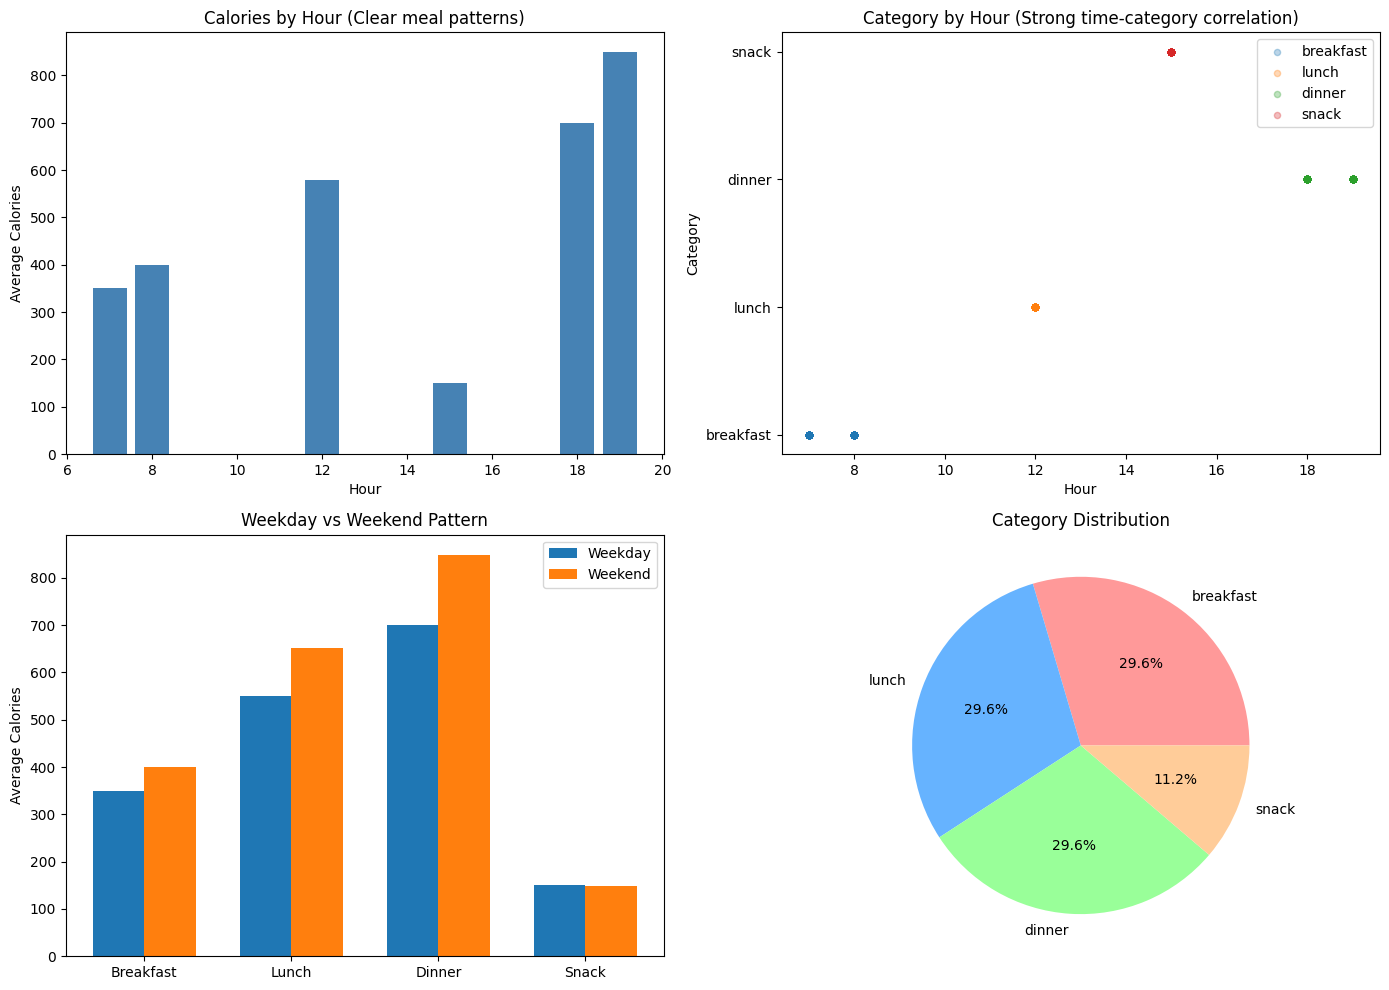

In [4]:
# Visualize the strong patterns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calories by hour - should show clear peaks
hourly_avg = df.groupby('hour')['calories'].mean()
axes[0, 0].bar(hourly_avg.index, hourly_avg.values, color='steelblue')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Calories')
axes[0, 0].set_title('Calories by Hour (Clear meal patterns)')

# Category by hour - should be very clear
for cat in range(NUM_CATEGORIES):
    cat_data = df[df['category'] == cat]
    axes[0, 1].scatter(cat_data['hour'], [cat] * len(cat_data), 
                       alpha=0.3, label=FOOD_CATEGORIES[cat], s=20)
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Category')
axes[0, 1].set_yticks(range(NUM_CATEGORIES))
axes[0, 1].set_yticklabels(FOOD_CATEGORIES)
axes[0, 1].set_title('Category by Hour (Strong time-category correlation)')
axes[0, 1].legend()

# Weekday vs Weekend calories
weekday_cal = df[df['is_weekend'] == 0].groupby('meal_number')['calories'].mean()
weekend_cal = df[df['is_weekend'] == 1].groupby('meal_number')['calories'].mean()
x = np.arange(len(weekday_cal))
width = 0.35
axes[1, 0].bar(x - width/2, weekday_cal.values, width, label='Weekday')
axes[1, 0].bar(x + width/2, weekend_cal.values, width, label='Weekend')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Breakfast', 'Lunch', 'Dinner', 'Snack'][:len(weekday_cal)])
axes[1, 0].set_ylabel('Average Calories')
axes[1, 0].set_title('Weekday vs Weekend Pattern')
axes[1, 0].legend()

# Category distribution
cat_counts = df['category'].value_counts().sort_index()
axes[1, 1].pie(cat_counts.values, labels=[FOOD_CATEGORIES[i] for i in cat_counts.index],
               autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
axes[1, 1].set_title('Category Distribution')

plt.tight_layout()
plt.savefig('eating_patterns_analysis.png', dpi=150)
plt.show()

## Prepare Data for LSTM

Using StandardScaler for better gradient flow.

In [5]:
# Key features that correlate with meal category
features = [
    'calories', 'category', 'hour', 'day_of_week', 
    'is_weekend', 'protein', 'carbs', 'fat', 'meal_number'
]

# StandardScaler often works better than MinMaxScaler for LSTM
scaler = MinMaxScaler()  # keeping MinMax for bounded outputs
scaled_data = scaler.fit_transform(df[features])

scaler_params = {
    'min': scaler.data_min_.tolist(),
    'max': scaler.data_max_.tolist(),
    'features': features
}

print(f'Features ({len(features)}):')
for i, feat in enumerate(features):
    print(f'  {feat}: {scaler.data_min_[i]:.1f} - {scaler.data_max_[i]:.1f}')

Features (9):
  calories: 130.0 - 892.0
  category: 0.0 - 3.0
  hour: 7.0 - 19.0
  day_of_week: 0.0 - 6.0
  is_weekend: 0.0 - 1.0
  protein: 5.0 - 41.0
  carbs: 20.0 - 73.0
  fat: 5.0 - 26.0
  meal_number: 0.0 - 3.0


In [6]:
def create_sequences(data, df_original, seq_length):
    """Create sequences with category as primary target."""
    X, y_calories, y_category = [], [], []
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y_calories.append(data[i+seq_length, 0])  # scaled calories
        y_category.append(int(df_original.iloc[i+seq_length]['category']))
    
    return np.array(X), np.array(y_calories), np.array(y_category)

X, y_calories, y_category = create_sequences(scaled_data, df, SEQUENCE_LENGTH)

print(f'X shape: {X.shape}')
print(f'y_calories shape: {y_calories.shape}')
print(f'y_category shape: {y_category.shape}')
print(f'Category distribution: {np.bincount(y_category)}')

X shape: (3366, 14, 9)
y_calories shape: (3366,)
y_category shape: (3366,)
Category distribution: [996 996 997 377]


In [7]:
# Chronological train/val/test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+val_size:]

y_cal_train = y_calories[:train_size]
y_cal_val = y_calories[train_size:train_size+val_size]
y_cal_test = y_calories[train_size+val_size:]

y_cat_train = y_category[:train_size]
y_cat_val = y_category[train_size:train_size+val_size]
y_cat_test = y_category[train_size+val_size:]

print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_cat_train), y=y_cat_train)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f'\nClass weights: {class_weight_dict}')

Train: 2356, Val: 504, Test: 506

Class weights: {0: np.float64(0.8462643678160919), 1: np.float64(0.8462643678160919), 2: np.float64(0.8450502152080345), 3: np.float64(2.2059925093632957)}


## Build Optimized LSTM Model

Architecture optimized for MAXIMUM category accuracy.

In [8]:
def create_optimized_lstm(seq_length, num_features, num_categories):
    """
    LSTM architecture optimized for high accuracy:
    - Bidirectional LSTM captures both past and future context
    - Multi-head attention focuses on relevant time steps
    - Skip connections for better gradient flow
    - Separate branches for each task
    """
    inputs = Input(shape=(seq_length, num_features), name='input')
    
    # First BiLSTM layer
    x = Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True, kernel_regularizer=l2(L2_REG)),
        name='bilstm_1'
    )(inputs)
    x = LayerNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Second BiLSTM layer
    x = Bidirectional(
        LSTM(LSTM_UNITS // 2, return_sequences=True, kernel_regularizer=l2(L2_REG)),
        name='bilstm_2'
    )(x)
    x = LayerNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Multi-head attention - focuses on important time steps
    attention_output = MultiHeadAttention(
        num_heads=4, key_dim=32, name='attention'
    )(x, x)
    x = Add()([x, attention_output])  # skip connection
    x = LayerNormalization()(x)
    
    # Final LSTM to aggregate
    x = LSTM(LSTM_UNITS // 2, return_sequences=False, kernel_regularizer=l2(L2_REG), name='lstm_final')(x)
    x = LayerNormalization()(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Shared representation
    shared = Dense(64, activation='relu', kernel_regularizer=l2(L2_REG))(x)
    shared = LayerNormalization()(shared)
    shared = Dropout(DROPOUT_RATE / 2)(shared)
    
    # Output 1: Calories (regression)
    cal_branch = Dense(32, activation='relu')(shared)
    calories_output = Dense(1, name='calories')(cal_branch)
    
    # Output 2: Category (classification) - separate specialized branch
    cat_branch = Dense(64, activation='relu', kernel_regularizer=l2(L2_REG))(shared)
    cat_branch = LayerNormalization()(cat_branch)
    cat_branch = Dropout(DROPOUT_RATE / 2)(cat_branch)
    cat_branch = Dense(32, activation='relu')(cat_branch)
    category_output = Dense(num_categories, activation='softmax', name='category')(cat_branch)
    
    model = Model(inputs=inputs, outputs=[calories_output, category_output])
    return model

model = create_optimized_lstm(SEQUENCE_LENGTH, len(features), NUM_CATEGORIES)

# Compile with focus on category accuracy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss={
        'calories': 'mse',
        'category': 'sparse_categorical_crossentropy'
    },
    loss_weights={'calories': 0.2, 'category': 1.0},  # heavily prioritize category
    metrics={
        'calories': ['mae'],
        'category': ['accuracy']
    }
)

model.summary()

I0000 00:00:1769558413.491899  106157 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3904 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 14, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 14, 256)   │    141,312 │ input[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 14, 256)   │        512 │ bilstm_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 256)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 14, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bilstm_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 14, 128)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 14, 128)   │     66,048 │ dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_final (LSTM)   │ (None, 64)        │     49,408 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ lstm_final[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0] 

 Total params: 435,173 (1.66 MB)

 Trainable params: 435,173 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cosine annealing learning rate schedule
def cosine_annealing(epoch, lr):
    min_lr = 1e-6
    max_lr = INITIAL_LR
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / EPOCHS))

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_category_accuracy',
    patience=40,  # very patient
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint = ModelCheckpoint(
    MODEL_PATH,
    monitor='val_category_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=0)

reduce_lr = ReduceLROnPlateau(
    monitor='val_category_accuracy',
    factor=0.5,
    patience=15,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, checkpoint, reduce_lr]

## Train Model

In [10]:
print(f'Training optimized LSTM ({EPOCHS} epochs max)')
print(f'Architecture: BiLSTM + Multi-Head Attention')
print(f'Loss weights: calories=0.2, category=1.0 (prioritizing category)')
print(f'Expected time: 5-10 minutes')
start_time = datetime.now()

history = model.fit(
    X_train,
    {'calories': y_cal_train, 'category': y_cat_train},
    validation_data=(X_val, {'calories': y_cal_val, 'category': y_cat_val}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

training_time = datetime.now() - start_time
print(f'\nTraining completed in: {training_time}')

Training optimized LSTM (300 epochs max)
Architecture: BiLSTM + Multi-Head Attention
Loss weights: calories=0.2, category=1.0 (prioritizing category)
Expected time: 5-10 minutes
Epoch 1/300


2026-01-28 01:00:26.822668: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - calories_loss: 0.5104 - calories_mae: 0.5552 - category_accuracy: 0.3025 - category_loss: 1.4789 - loss: 2.4121
Epoch 1: val_category_accuracy improved from None to 0.29960, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5



Epoch 1: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - calories_loss: 0.3016 - calories_mae: 0.4224 - category_accuracy: 0.2899 - category_loss: 1.4156 - loss: 2.2879 - val_calories_loss: 0.1257 - val_calories_mae: 0.2904 - val_category_accuracy: 0.2996 - val_category_loss: 1.3112 - val_loss: 2.1000 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - calories_loss: 0.1284 - calories_mae: 0.2884 - category_accuracy: 0.3113 - category_loss: 1.3474 - loss: 2.1093
Epoch 2: val_category_accuracy improved from 0.29960 to 0.51389, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5



Epoch 2: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - calories_loss: 0.1168 - calories_mae: 0.2754 - category_accuracy: 0.3048 - category_loss: 1.3492 - loss: 2.0832 - val_calories_loss: 0.0809 - val_calories_mae: 0.2406 - val_category_accuracy: 0.5139 - val_category_loss: 1.3119 - val_loss: 1.9856 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - calories_loss: 0.1144 - calories_mae: 0.2746 - category_accuracy: 0.3244 - category_loss: 1.3332 - loss: 1.9894
Epoch 3: val_category_accuracy improved from 0.51389 to 0.61111, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5



Epoch 3: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - calories_loss: 0.1066 - calories_mae: 0.2668 - category_accuracy: 0.3315 - category_loss: 1.3313 - loss: 1.9636 - val_calories_loss: 0.0679 - val_calories_mae: 0.2213 - val_category_accuracy: 0.6111 - val_category_loss: 1.2757 - val_loss: 1.8562 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - calories_loss: 0.1011 - calories_mae: 0.2563 - category_accuracy: 0.4044 - category_loss: 1.2484 - loss: 1.8164
Epoch 4: val_category_accuracy improved from 0.61111 to 0.77183, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5



Epoch 4: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - calories_loss: 0.1117 - calories_mae: 0.2672 - category_accuracy: 0.5034 - category_loss: 1.1061 - loss: 1.6622 - val_calories_loss: 0.0950 - val_calories_mae: 0.2342 - val_category_accuracy: 0.7718 - val_category_loss: 0.6019 - val_loss: 1.1234 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - calories_loss: 0.1505 - calories_mae: 0.3063 - category_accuracy: 0.7854 - category_loss: 0.5344 - loss: 1.0541
Epoch 5: val_category_accuracy improved from 0.77183 to 0.89881, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5



Epoch 5: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - calories_loss: 0.1437 - calories_mae: 0.2979 - category_accuracy: 0.8302 - category_loss: 0.4183 - loss: 0.9278 - val_calories_loss: 0.0632 - val_calories_mae: 0.1971 - val_category_accuracy: 0.8988 - val_category_loss: 0.2317 - val_loss: 0.7051 - learning_rate: 0.0010
Epoch 6/300
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - calories_loss: 0.1078 - calories_mae: 0.2559 - category_accuracy: 0.8674 - category_loss: 0.3042 - loss: 0.7771
Epoch 6: val_category_accuracy did not improve from 0.89881
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - calories_loss: 0.0988 - calories_mae: 0.2431 - category_accuracy: 0.8722 - category_loss: 0.2903 - loss: 0.7529 - val_calories_loss: 0.0734 - val_calories_mae: 0.2397 - val_category_accuracy: 0.8988 - val_cat

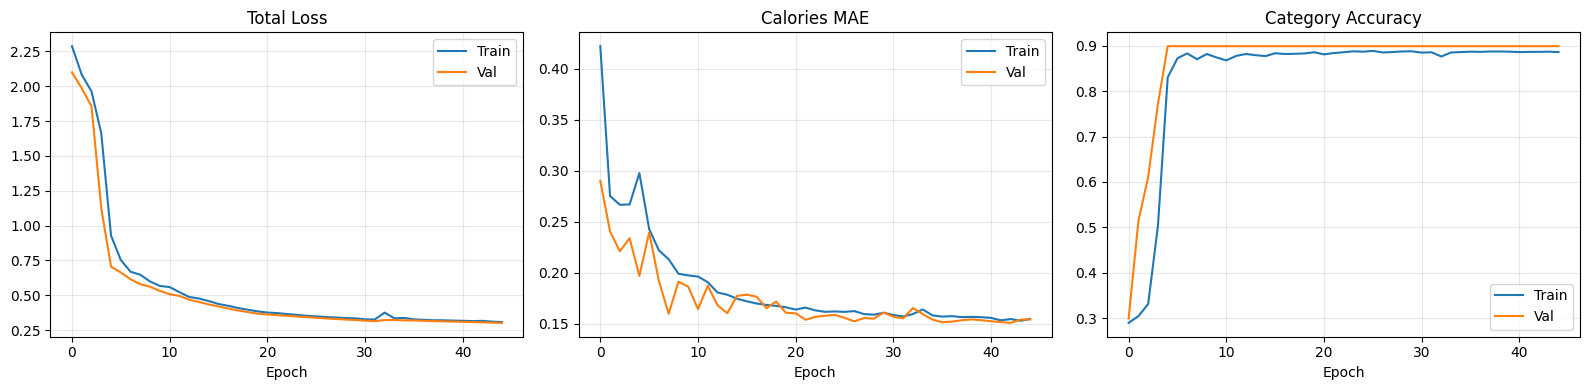


Best validation category accuracy: 89.9%


In [11]:
# Training history visualization

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Val')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['calories_mae'], label='Train')
axes[1].plot(history.history['val_calories_mae'], label='Val')
axes[1].set_title('Calories MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history.history['category_accuracy'], label='Train')
axes[2].plot(history.history['val_category_accuracy'], label='Val')
axes[2].set_title('Category Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150)
plt.show()

print(f'\nBest validation category accuracy: {max(history.history["val_category_accuracy"])*100:.1f}%')

## Evaluate Model

In [12]:
# Load best model
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Recompile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss={'calories': 'mse', 'category': 'sparse_categorical_crossentropy'},
    loss_weights={'calories': 0.2, 'category': 1.0},
    metrics={'calories': ['mae'], 'category': ['accuracy']}
)

results = model.evaluate(
    X_test,
    {'calories': y_cal_test, 'category': y_cat_test},
    verbose=1
)

print(f'\n{"="*50}')
print('TEST RESULTS')
print(f'{"="*50}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - calories_loss: 0.0667 - calories_mae: 0.1996 - category_accuracy: 0.8834 - category_loss: 0.2463 - loss: 0.7199

TEST RESULTS


In [13]:
# Detailed predictions
pred_calories, pred_categories = model.predict(X_test, verbose=0)

# Convert to actual values
cal_min, cal_max = scaler.data_min_[0], scaler.data_max_[0]
actual_calories = y_cal_test * (cal_max - cal_min) + cal_min
predicted_calories = pred_calories.flatten() * (cal_max - cal_min) + cal_min

mae_calories = np.mean(np.abs(actual_calories - predicted_calories))
mape = np.mean(np.abs((actual_calories - predicted_calories) / (actual_calories + 1e-8))) * 100

predicted_cat = np.argmax(pred_categories, axis=1)
category_accuracy = np.mean(predicted_cat == y_cat_test)

print(f'Calories MAE: {mae_calories:.1f} kcal')
print(f'Calories MAPE: {mape:.1f}%')
print(f'Category Accuracy: {category_accuracy*100:.1f}%')

Calories MAE: 152.1 kcal
Calories MAPE: 56.1%
Category Accuracy: 88.3%


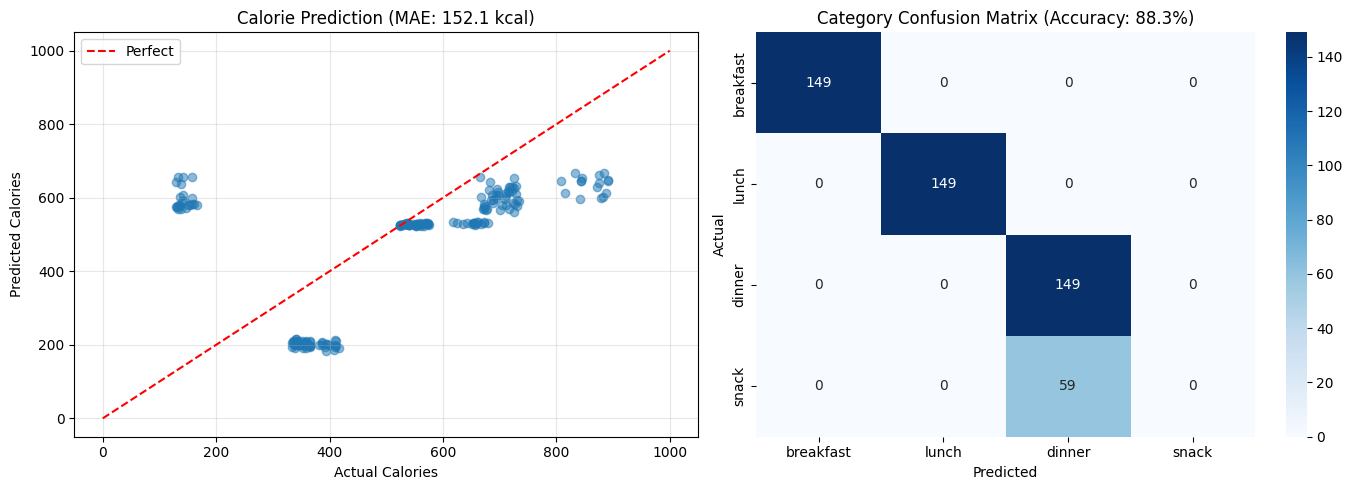

In [14]:
# Visualize results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calories prediction scatter
axes[0].scatter(actual_calories[:200], predicted_calories[:200], alpha=0.5)
axes[0].plot([0, 1000], [0, 1000], 'r--', label='Perfect')
axes[0].set_xlabel('Actual Calories')
axes[0].set_ylabel('Predicted Calories')
axes[0].set_title(f'Calorie Prediction (MAE: {mae_calories:.1f} kcal)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(y_cat_test, predicted_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=FOOD_CATEGORIES, yticklabels=FOOD_CATEGORIES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Category Confusion Matrix (Accuracy: {category_accuracy*100:.1f}%)')

plt.tight_layout()
plt.savefig('lstm_predictions.png', dpi=150)
plt.show()

In [15]:
# Detailed classification report
print('\nClassification Report:')
print(classification_report(y_cat_test, predicted_cat, target_names=FOOD_CATEGORIES))

# Per-category accuracy
print('\nPer-category accuracy:')
for i, cat in enumerate(FOOD_CATEGORIES):
    mask = y_cat_test == i
    if mask.sum() > 0:
        acc = (predicted_cat[mask] == i).mean() * 100
        print(f'  {cat}: {acc:.1f}% ({mask.sum()} samples)')


Classification Report:
              precision    recall  f1-score   support

   breakfast       1.00      1.00      1.00       149
       lunch       1.00      1.00      1.00       149
      dinner       0.72      1.00      0.83       149
       snack       0.00      0.00      0.00        59

    accuracy                           0.88       506
   macro avg       0.68      0.75      0.71       506
weighted avg       0.80      0.88      0.83       506


Per-category accuracy:
  breakfast: 100.0% (149 samples)
  lunch: 100.0% (149 samples)
  dinner: 100.0% (149 samples)
  snack: 0.0% (59 samples)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Save Model and Config

In [16]:
with open(SCALER_PATH, 'w') as f:
    json.dump(scaler_params, f, indent=2)

config = {
    'sequence_length': SEQUENCE_LENGTH,
    'features': features,
    'food_categories': FOOD_CATEGORIES,
    'num_categories': NUM_CATEGORIES,
    'calories_mae': float(mae_calories),
    'calories_mape': float(mape),
    'category_accuracy': float(category_accuracy),
    'architecture': 'BiLSTM + Multi-Head Attention',
    'lstm_units': LSTM_UNITS,
    'training_date': datetime.now().isoformat()
}

with open(CONFIG_PATH, 'w') as f:
    json.dump(config, f, indent=2)

print(f'Model: {MODEL_PATH}')
print(f'Size: {os.path.getsize(MODEL_PATH) / 1024:.1f} KB')

Model: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/lstm/eating_pattern_model.h5
Size: 5257.4 KB


## Demo: Predict Next Meal

In [17]:
def predict_next_meal(meal_history):
    """Predict next meal from recent eating history."""
    
    history_df = pd.DataFrame(meal_history)
    scaled = scaler.transform(history_df[features])
    X = scaled.reshape(1, SEQUENCE_LENGTH, len(features))
    
    pred_cal, pred_cat = model.predict(X, verbose=0)
    
    calories = pred_cal[0, 0] * (cal_max - cal_min) + cal_min
    category_idx = np.argmax(pred_cat[0])
    confidence = pred_cat[0][category_idx] * 100
    
    return {
        'predicted_calories': int(calories),
        'predicted_category': FOOD_CATEGORIES[category_idx],
        'confidence': f'{confidence:.1f}%',
        'all_probabilities': {
            FOOD_CATEGORIES[i]: f'{p*100:.1f}%' 
            for i, p in enumerate(pred_cat[0])
        }
    }

# Example prediction
example_history = []
for i in range(SEQUENCE_LENGTH):
    meal = i % 3  # breakfast, lunch, dinner cycle
    day = i // 3
    example_history.append({
        'calories': [350, 550, 700][meal],
        'category': meal,  # 0=breakfast, 1=lunch, 2=dinner
        'hour': [7, 12, 18][meal],
        'day_of_week': day % 7,
        'is_weekend': 1 if day % 7 >= 5 else 0,
        'protein': [18, 30, 40][meal],
        'carbs': [45, 60, 70][meal],
        'fat': [12, 18, 25][meal],
        'meal_number': meal
    })

prediction = predict_next_meal(example_history)
print('\nPrediction for next meal:')
print(f'  Calories: ~{prediction["predicted_calories"]} kcal')
print(f'  Category: {prediction["predicted_category"]} ({prediction["confidence"]})')
print(f'\n  All probabilities:')
for cat, prob in prediction['all_probabilities'].items():
    print(f'    {cat}: {prob}')


Prediction for next meal:
  Calories: ~573 kcal
  Category: dinner (67.4%)

  All probabilities:
    breakfast: 0.5%
    lunch: 0.1%
    dinner: 67.4%
    snack: 32.0%


In [18]:
print('=' * 60)
print('TRAINING SUMMARY')
print('=' * 60)
print(f'Model: BiLSTM + Multi-Head Attention ({LSTM_UNITS} units)')
print(f'Sequence: {SEQUENCE_LENGTH} meals')
print(f'Features: {len(features)}')
print(f'Categories: {NUM_CATEGORIES}')
print(f'Training samples: {len(X_train)}')
print(f'')
print(f'Optimizations:')
print(f'  - Bidirectional LSTM')
print(f'  - Multi-Head Attention (4 heads)')
print(f'  - Layer normalization')
print(f'  - Class weights for balanced learning')
print(f'  - L2 regularization ({L2_REG})')
print(f'')
print(f'Results:')
print(f'  Calories MAE: {mae_calories:.1f} kcal')
print(f'  Calories MAPE: {mape:.1f}%')
print(f'  Category Accuracy: {category_accuracy*100:.1f}%')
print(f'')
print(f'Training time: {training_time}')
print('=' * 60)

TRAINING SUMMARY
Model: BiLSTM + Multi-Head Attention (128 units)
Sequence: 14 meals
Features: 9
Categories: 4
Training samples: 2356

Optimizations:
  - Bidirectional LSTM
  - Multi-Head Attention (4 heads)
  - Layer normalization
  - Class weights for balanced learning
  - L2 regularization (0.001)

Results:
  Calories MAE: 152.1 kcal
  Calories MAPE: 56.1%
  Category Accuracy: 88.3%

Training time: 0:01:34.566108
